In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlwt 
from xlwt import Workbook 
# from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

print('Libraries Loaded')

Libraries Loaded


In [3]:
def read_file(path):
    '''
    Returns the dataframe which is read from the excel file present in the path specified. 
    
    Parameters:
        path (str) : The path of the file
    
    Returns:
        df (float) : The dataframe which is created after reading the file.
    '''
    df= pd.read_excel(path)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    print(df.shape)
    print(df.head())
    return df

def create_dataset(X, y, time_steps, ts_range):
    '''
    Returns the prepared data based on the lag and look ahead
    
    Parameters:
        X          (float): The independent variables of the data
        y          (float): The dependent variables of the data
        time_steps (int)  : The lag that is being used to lookback
        ts_range   (int)  : The lookahead for the data
    
    Returns:
        Xs (float) : The numpy array of the input variable
        ys (float) : The numpy array of the output variable 
    '''
    Xs, ys = [], []
    for i in range(len(X) - time_steps - ts_range):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.values[(i + time_steps):(i + time_steps + ts_range),0])
    return np.array(Xs), np.array(ys)

def splitter(df,output,lag,duration,ts):
    '''
    Returns the training and testing data
    
    Parameters:
        df (float): The whole dataframe containing the independent and dependent variables
        output(str): The output variable 
        lag (int): The lag that needs to be applied for the data
        duration (int): The duration that is being considered as output
        ts (float): The percentage of training data
    
    Returns:
        x_train (float): The training data of independent variable 
        x_test (float): The testing data of independent variable
        y_train (float): The training data of the depenedent variable 
        y_test (float): The testing data of the dependent variable 
    '''
    assert (0. <= ts <= 1.)
    train_size = int(len(df) * ts)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df[train_size:]
    print(train.shape, test.shape)
    scaler,scaler_single = MinMaxScaler(feature_range=(0, 1)),MinMaxScaler(feature_range=(0, 1))

    scaler.fit(train)
    scaler_single.fit(train[output])

    train_scaled = pd.DataFrame(scaler.transform(train), columns=[df.columns])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=[df.columns])

    df_train = train_scaled.copy(deep=True)
    df_test = test_scaled.copy(deep=True)

    x_train,y_train = create_dataset(df_train,df_train[[output]],lag,duration)
    x_test, y_test = create_dataset(df_test, df_test[[output]], lag, duration)

    return x_train,x_test,y_train,y_test,scaler_single

class attention(keras.layers.Layer):
    '''
    Attention layer for the neural networks.
    
    if return_sequences=True, it will give 3D vector and if false it will give 2D vector. It is same as LSTMs.

    https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137
    the  following code is being inspired from the above link.
    '''

    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def get_config(self):
        cfg = super().get_config()
        return cfg

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

In [5]:
## Specifying the source path
src = r'D:\Pavement-Temperature-Prediction\Data\Pave_data_cleaned.xlsx'
# filename = r'Pave_data_cleaned.xlsx'

## Specifying the destination path
dest = r'D:\Pavement-Temperature-Prediction\Results\Six Hours Lag'

## Reading the file
df = read_file(src)

(10896, 7)
   Year  Month  Day  Hour  Temp  Solar  Pavement
0  2009     11    1     1   8.4    0.0  9.333333
1  2009     11    1     2   8.3    0.0  8.933333
2  2009     11    1     3   7.9    0.0  8.700000
3  2009     11    1     4   7.6    0.0  8.533333
4  2009     11    1     5   6.9    0.0  8.533333


In [6]:
## Creating the training and testing data
x_train,x_test,y_train,y_test,scaler = splitter(df[['Temp','Pavement']],['Pavement'],6,6,0.8)
print(f'The shape of x_train is {x_train.shape} and x_test is {x_test.shape}')
print(f'The shape of y_train is {y_train.shape} and y_test is {y_test.shape}')

(8716, 2) (2180, 2)
The shape of x_train is (8704, 6, 2) and x_test is (2168, 6, 2)
The shape of y_train is (8704, 6) and y_test is (2168, 6)


In [12]:
## Creating the prelimaries 

filepath_simple_bn = 'simple_lstm_bn.hdf5'
filepath_simple_l2 = 'simple_lstm_l2.hdf5'

filepath_attention_bn = 'attention_lstm_bn.hdf5'
filepath_attention_l2 = 'attention_lstm_l2.hdf5'

checkpoint_simple_bn = keras.callbacks.ModelCheckpoint(filepath_simple_bn,monitor='val_loss',save_best_only=True)
checkpoint_simple_l2 = keras.callbacks.ModelCheckpoint(filepath_simple_l2,monitor='val_loss',save_best_only=True)

checkpoint_attention_bn = keras.callbacks.ModelCheckpoint(filepath_attention_bn, monitor='val_loss',save_best_only=True)
checkpoint_attention_l2 = keras.callbacks.ModelCheckpoint(filepath_attention_l2, monitor='val_loss',save_best_only=True)

# wk=Workbook()
# sheet1 = wk.add_sheet('Simple_BN', cell_overwrite_ok=True)
# sheet2 = wk.add_sheet('Attention_BN', cell_overwrite_ok=True)
# sheet3 = wk.add_sheet('Simple_L2', cell_overwrite_ok=True)
# sheet4 = wk.add_sheet('Attention_L2', cell_overwrite_ok=True)
# sheet5 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [8]:
## Simple LSTM
K.clear_session()
simple_lstm_bn = keras.Sequential()
simple_lstm_bn.add(keras.layers.BatchNormalization())
simple_lstm_bn.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
simple_lstm_bn.add(keras.layers.BatchNormalization())
simple_lstm_bn.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm_bn.add(keras.layers.BatchNormalization())
simple_lstm_bn.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm_bn.add(keras.layers.BatchNormalization())
simple_lstm_bn.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm_bn.add(keras.layers.Flatten())
simple_lstm_bn.add(keras.layers.Dense(512, activation='relu'))
simple_lstm_bn.add(keras.layers.Dense(128, activation='relu'))
simple_lstm_bn.add(keras.layers.Dense(64, activation='relu'))
simple_lstm_bn.add(keras.layers.Dropout(0.3))
simple_lstm_bn.add(keras.layers.Dense(32))
simple_lstm_bn.add(keras.layers.Dense(6))

simple_lstm_bn.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

==============] - 2s 9ms/step - loss: 0.0022 - mae: 0.0351 - val_loss: 8.1538e-04 - val_mae: 0.0210
Epoch 56/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0021 - mae: 0.0335 - val_loss: 8.2462e-04 - val_mae: 0.0202
Epoch 57/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0021 - mae: 0.0337 - val_loss: 9.3211e-04 - val_mae: 0.0229
Epoch 58/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0021 - mae: 0.0330 - val_loss: 0.0014 - val_mae: 0.0293
Epoch 59/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0022 - mae: 0.0345 - val_loss: 0.0010 - val_mae: 0.0227
Epoch 60/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0022 - mae: 0.0344 - val_loss: 8.4493e-04 - val_mae: 0.0209
Epoch 61/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0020 - mae: 0.0330 - val_loss: 0.0011 - val_mae: 0.0240
Epoch 62/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0020 

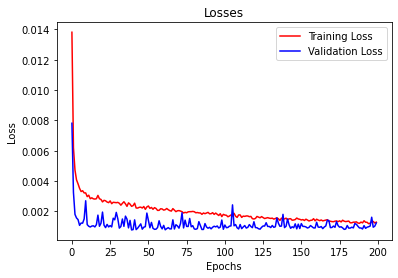

The Mean Squared Error is: 13.285198520864379


In [10]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM1')
    os.chdir(os.path.join(dest,'LSTM'))
    print('New Directory Created')

history = simple_lstm_bn.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

simple_lstm_bn.load_weights(filepath_simple)
preds = simple_lstm_bn.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [11]:
## Simple LSTM
K.clear_session()
simple_lstm_l2 = keras.Sequential()
# simple_lstm_l2.add(keras.layers.BatchNormalization())
simple_lstm_l2.add(keras.layers.LSTM(64, return_sequences=True, kernel_regularizer='l2',input_shape=(x_train.shape[1], x_train.shape[2])))
# simple_lstm_l2.add(keras.layers.BatchNormalization())
simple_lstm_l2.add(keras.layers.LSTM(64, kernel_regularizer='l2',return_sequences=True))
# simple_lstm_l2.add(keras.layers.BatchNormalization())
simple_lstm_l2.add(keras.layers.LSTM(64, kernel_regularizer='l2',return_sequences=True))
# simple_lstm_l2.add(keras.layers.BatchNormalization())
simple_lstm_l2.add(keras.layers.LSTM(64, kernel_regularizer='l2',return_sequences=True))
simple_lstm_l2.add(keras.layers.Flatten())
simple_lstm_l2.add(keras.layers.Dense(512, activation='relu'))
simple_lstm_l2.add(keras.layers.Dense(128, activation='relu'))
simple_lstm_l2.add(keras.layers.Dense(64, activation='relu'))
simple_lstm_l2.add(keras.layers.Dropout(0.3))
simple_lstm_l2.add(keras.layers.Dense(32))
simple_lstm_l2.add(keras.layers.Dense(6))

simple_lstm_l2.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

 - loss: 0.0183 - mae: 0.1044 - val_loss: 0.0179 - val_mae: 0.1069
Epoch 53/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0183 - mae: 0.1045 - val_loss: 0.0171 - val_mae: 0.1039
Epoch 54/200
245/245 [==============================] - 2s 9ms/step - loss: 0.0183 - mae: 0.1045 - val_loss: 0.0165 - val_mae: 0.1016
Epoch 55/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0183 - mae: 0.1044 - val_loss: 0.0158 - val_mae: 0.0992
Epoch 56/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0183 - mae: 0.1044 - val_loss: 0.0177 - val_mae: 0.1061
Epoch 57/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0183 - mae: 0.1045 - val_loss: 0.0171 - val_mae: 0.1038
Epoch 58/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0183 - mae: 0.1045 - val_loss: 0.0173 - val_mae: 0.1048
Epoch 59/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0183 - mae: 0.1044 - val_loss: 0.0168 - val_mae: 0.

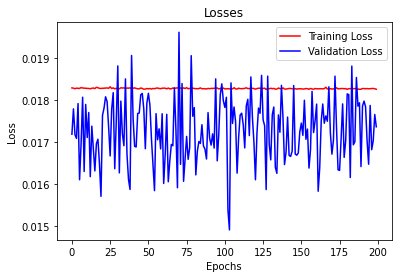

The Mean Squared Error is: 88.73912953149659


In [14]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM1')
    os.chdir(os.path.join(dest,'LSTM'))
    print('New Directory Created')

history = simple_lstm_l2.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple_l2])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

simple_lstm_l2.load_weights(filepath_simple_l2)
preds = simple_lstm_l2.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet3.write(0, 0, 'MSE')
        sheet3.write(0, 1, 'Hours Ahead')
        sheet3.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet3.write(i + 1, 1, i+1)


In [20]:
## Attention model
K.clear_session()
atten_lstm_bn = keras.Sequential()
atten_lstm_bn.add(keras.layers.BatchNormalization())
atten_lstm_bn.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
atten_lstm_bn.add(keras.layers.BatchNormalization())
atten_lstm_bn.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm_bn.add(keras.layers.BatchNormalization())
atten_lstm_bn.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm_bn.add(keras.layers.BatchNormalization())
atten_lstm_bn.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm_bn.add(attention(return_sequences=True))
atten_lstm_bn.add(keras.layers.Flatten())
atten_lstm_bn.add(keras.layers.Dense(512, activation='relu'))
atten_lstm_bn.add(keras.layers.Dense(128, activation='relu'))
atten_lstm_bn.add(keras.layers.Dense(64, activation='relu'))
atten_lstm_bn.add(keras.layers.Dense(32))
atten_lstm_bn.add(keras.layers.Dense(6))

atten_lstm_bn.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

ss: 0.0013 - mae: 0.0267 - val_loss: 8.3313e-04 - val_mae: 0.0204
Epoch 58/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0013 - mae: 0.0262 - val_loss: 9.8201e-04 - val_mae: 0.0223
Epoch 59/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0013 - mae: 0.0258 - val_loss: 0.0011 - val_mae: 0.0238
Epoch 60/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0013 - mae: 0.0264 - val_loss: 8.3172e-04 - val_mae: 0.0205
Epoch 61/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0013 - mae: 0.0264 - val_loss: 9.9613e-04 - val_mae: 0.0236
Epoch 62/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0011 - mae: 0.0250 - val_loss: 9.5250e-04 - val_mae: 0.0221
Epoch 63/200
245/245 [==============================] - 2s 10ms/step - loss: 0.0014 - mae: 0.0275 - val_loss: 0.0011 - val_mae: 0.0249
Epoch 64/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0013 - mae: 0.0268 - val_loss

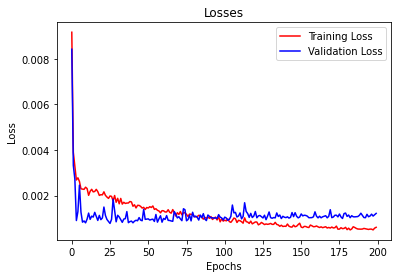

The Mean Squared Error is: 13.14754993147877


In [21]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'LSTM1'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM1')
    os.chdir(os.path.join(dest,'LSTM1'))
    print('New Directory Created')

history = atten_lstm_bn.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention_bn])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

atten_lstm_bn.load_weights(filepath_attention_bn)
preds = atten_lstm_bn.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)


In [24]:
## Attention model
K.clear_session()
atten_lstm_l2 = keras.Sequential()
# atten_lstm_l2.add(keras.layers.BatchNormalization())
atten_lstm_l2.add(keras.layers.LSTM(64, return_sequences=True,  kernel_regularizer='l2',input_shape=(x_train.shape[1], x_train.shape[2])))
# atten_lstm_l2.add(keras.layers.BatchNormalization())
atten_lstm_l2.add(keras.layers.LSTM(64, kernel_regularizer='l2', return_sequences=True))
# atten_lstm_l2.add(keras.layers.BatchNormalization())
atten_lstm_l2.add(keras.layers.LSTM(64,  kernel_regularizer='l2',return_sequences=True))
# atten_lstm_l2.add(keras.layers.BatchNormalization())
atten_lstm_l2.add(keras.layers.LSTM(64,  kernel_regularizer='l2',return_sequences=True))
atten_lstm_l2.add(attention(return_sequences=True))
atten_lstm_l2.add(keras.layers.Flatten())
atten_lstm_l2.add(keras.layers.Dense(512, activation='relu'))
atten_lstm_l2.add(keras.layers.Dense(128, activation='relu'))
atten_lstm_l2.add(keras.layers.Dense(64, activation='relu'))
atten_lstm_l2.add(keras.layers.Dense(32))
atten_lstm_l2.add(keras.layers.Dense(6))

atten_lstm_l2.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

86 - mae: 0.1050 - val_loss: 0.0170 - val_mae: 0.1038
Epoch 54/200
245/245 [==============================] - 3s 13ms/step - loss: 0.0189 - mae: 0.1062 - val_loss: 0.0177 - val_mae: 0.1062
Epoch 55/200
245/245 [==============================] - 3s 14ms/step - loss: 0.0184 - mae: 0.1051 - val_loss: 0.0145 - val_mae: 0.0941
Epoch 56/200
245/245 [==============================] - 3s 14ms/step - loss: 0.0195 - mae: 0.1080 - val_loss: 0.0177 - val_mae: 0.1061
Epoch 57/200
245/245 [==============================] - 3s 14ms/step - loss: 0.0186 - mae: 0.1057 - val_loss: 0.0176 - val_mae: 0.1057
Epoch 58/200
245/245 [==============================] - 3s 14ms/step - loss: 0.0176 - mae: 0.1031 - val_loss: 0.0180 - val_mae: 0.1074
Epoch 59/200
245/245 [==============================] - 3s 13ms/step - loss: 0.0184 - mae: 0.1055 - val_loss: 0.0183 - val_mae: 0.1086
Epoch 60/200
245/245 [==============================] - 3s 14ms/step - loss: 0.0186 - mae: 0.1055 - val_loss: 0.0174 - val_mae: 0.1049
E

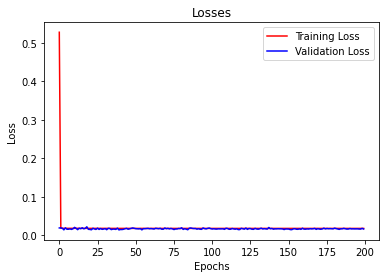

The Mean Squared Error is: 89.65544808768018


TypeError: save() missing 1 required positional argument: 'filename_or_stream'

In [25]:
## Saving the result file to the folder of the model
try:
    os.chdir(os.path.join(dest,'LSTM1'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM1')
    os.chdir(os.path.join(dest,'LSTM1'))
    print('New Directory Created')

history = atten_lstm_l2.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention_l2])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

atten_lstm_l2.load_weights(filepath_attention_l2)
preds = atten_lstm_l2.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet4.write(0, 0, 'MSE')
        sheet4.write(0, 1, 'Hours Ahead')
        sheet4.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet4.write(i + 1, 1, i+1)
wk.save()

In [26]:
wk.save('result.xlsx')

In [27]:
wk.save('result.xls')